# Jobs analytics

EasyApply Bot is a bot that helps you to apply to EasyApply offers on LinkedIn. Here is the project in case you are interested: https://github.com/nicolomantini/LinkedIn-Easy-Apply-Bot

Once you run this program every attempt to apply to a job gets recorded in a CSV file. I've been using the bot for a time and now I want to make some analytics in order to learn something new.

I set up the bot to look for jobs of data scientist, data engineer, data analyst, business intelligence and python.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jobs-applied-in-linkedin-with-easyapplybot/jobs.csv


In [2]:
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
my_filepath = "../input/jobs-applied-in-linkedin-with-easyapplybot/jobs.csv"

my_data = pd.read_csv(my_filepath,encoding='latin1')

my_data.head()

,timestamp,jobID,job,company,attempted,result
0,2020-09-09 18:01:14.040289,1998149634,Data Analytics / Data Scientist,Evolutio Empowering the cloud,True,True
1,2020-09-09 18:01:39.009284,2011446983,Data Scientist,Experis Selecciï¿½n,True,True
2,2020-09-09 18:02:03.471147,2011445130,Data Engineer,SoYou_Bankia,True,True
3,2020-09-09 18:02:18.523716,1990255850,Data Scientist Junior,Strategy Big Data,False,False
4,2020-09-09 18:02:44.209952,2011254160,Data Scientist,Daimler Group Services Madrid,True,True


Since there are some offers that will be constantly visited I will drop all the offers already seen.

In [4]:
non_duplicated = my_data.drop_duplicates(['jobID'])

print("Jobs found: ", len(non_duplicated['result']))
print("Successfully sent applications: ", non_duplicated['result'].value_counts()[1])
print("Failed applications: ", non_duplicated['result'].value_counts()[0])

Jobs found:  288
Successfully sent applications:  203
Failed applications:  85


Now we create two new columns from timestamp column.

In [5]:
import datetime
non_duplicated['date'] = non_duplicated.apply(lambda x: datetime.datetime.strptime(x['timestamp'], '%Y-%m-%d %H:%M:%S.%f').date(), axis = 1)
non_duplicated['time'] = non_duplicated.apply(lambda x: datetime.datetime.strptime(x['timestamp'], '%Y-%m-%d %H:%M:%S.%f').time(), axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Now we can drop timestamp column since it is already useless.

In [6]:
non_duplicated = non_duplicated.drop('timestamp', axis=1)

We can create some other columns related to date. They may be useful in the future.

In [7]:
non_duplicated['day'] = non_duplicated.apply(lambda x: x['date'].day, axis = 1)
non_duplicated['weekday'] = non_duplicated.apply(lambda x: x['date'].weekday(), axis = 1)
non_duplicated['month'] = non_duplicated.apply(lambda x: x['date'].month, axis = 1)
non_duplicated['week'] = non_duplicated.apply(lambda x: x['date'].isocalendar()[1], axis = 1)

I decided to transform 'attempted' and 'result' fields to be able to plot some graphs.

In [8]:
def convert_result(row):
    if row.result == True:
        row.result = 1
    else:
        row.result = 0
    return row

def convert_att(row):
    if row.attempted == True:
        row.attempted = 1
    else:
        row.attempted = 0
    return row

non_duplicated = non_duplicated.apply(convert_result, axis = 1)
non_duplicated = non_duplicated.apply(convert_att, axis = 1)

In [9]:
non_duplicated.head()

,jobID,job,company,attempted,result,date,time,day,weekday,month,week
0,1998149634,Data Analytics / Data Scientist,Evolutio Empowering the cloud,1,1,2020-09-09,18:01:14.040289,9,2,9,37
1,2011446983,Data Scientist,Experis Selecciï¿½n,1,1,2020-09-09,18:01:39.009284,9,2,9,37
2,2011445130,Data Engineer,SoYou_Bankia,1,1,2020-09-09,18:02:03.471147,9,2,9,37
3,1990255850,Data Scientist Junior,Strategy Big Data,0,0,2020-09-09,18:02:18.523716,9,2,9,37
4,2011254160,Data Scientist,Daimler Group Services Madrid,1,1,2020-09-09,18:02:44.209952,9,2,9,37


Now I group the data per day, counting every attempt and every successful submitting.

In [10]:
group = non_duplicated[['date','attempted', 'result']].groupby(['date']).sum()

group.head()

,attempted,result
date,,
2020-09-09,16,14
2020-09-10,15,10
2020-09-11,13,12
2020-09-12,6,5
2020-09-13,7,4


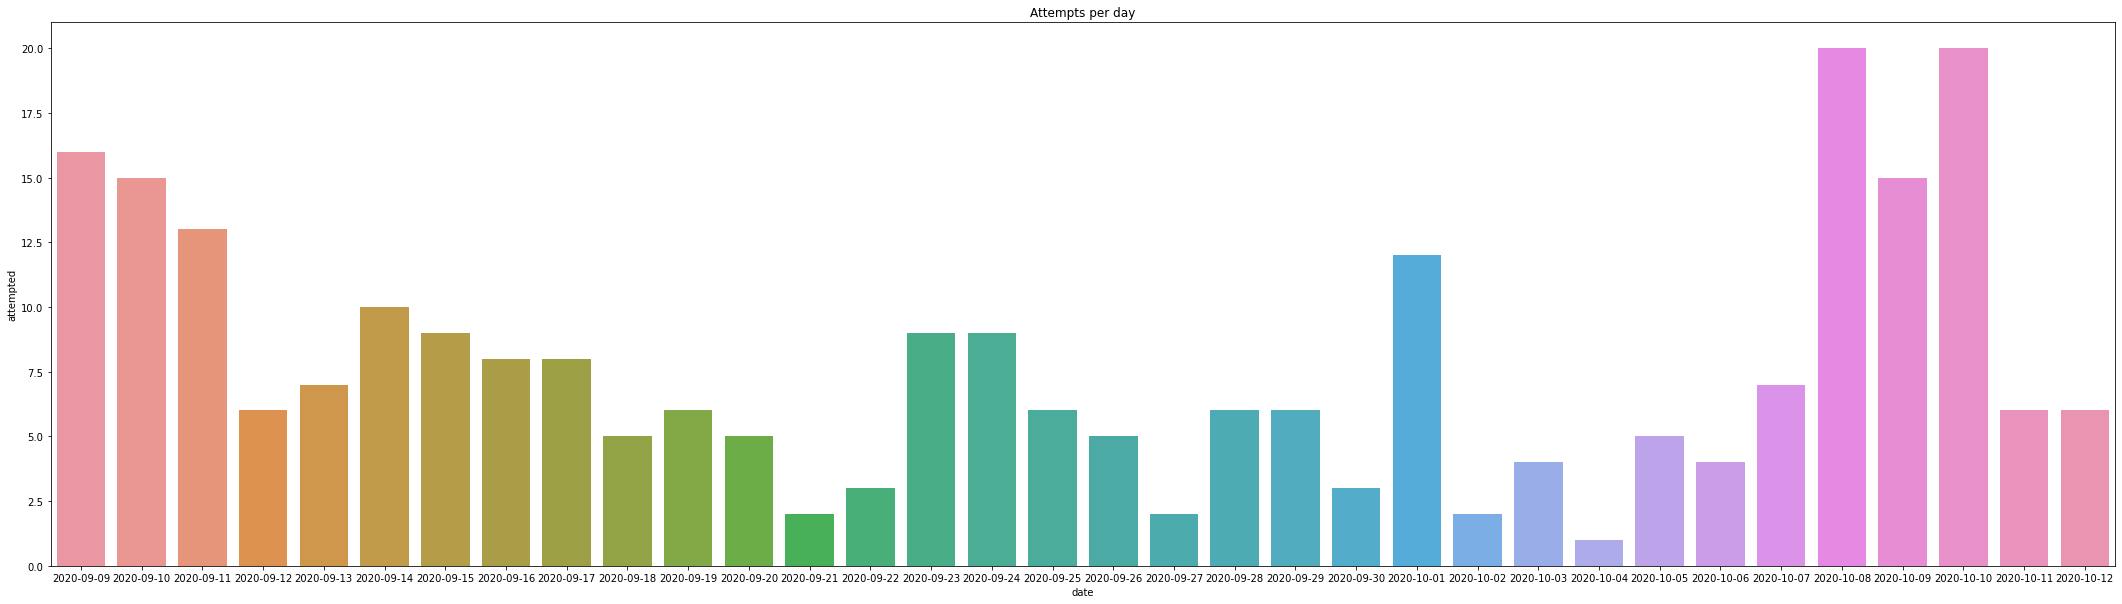

In [11]:
plt.figure(figsize=(37,10))
plt.title("Attempts per day")

sns.barplot(x=group.index, y=group['attempted'])

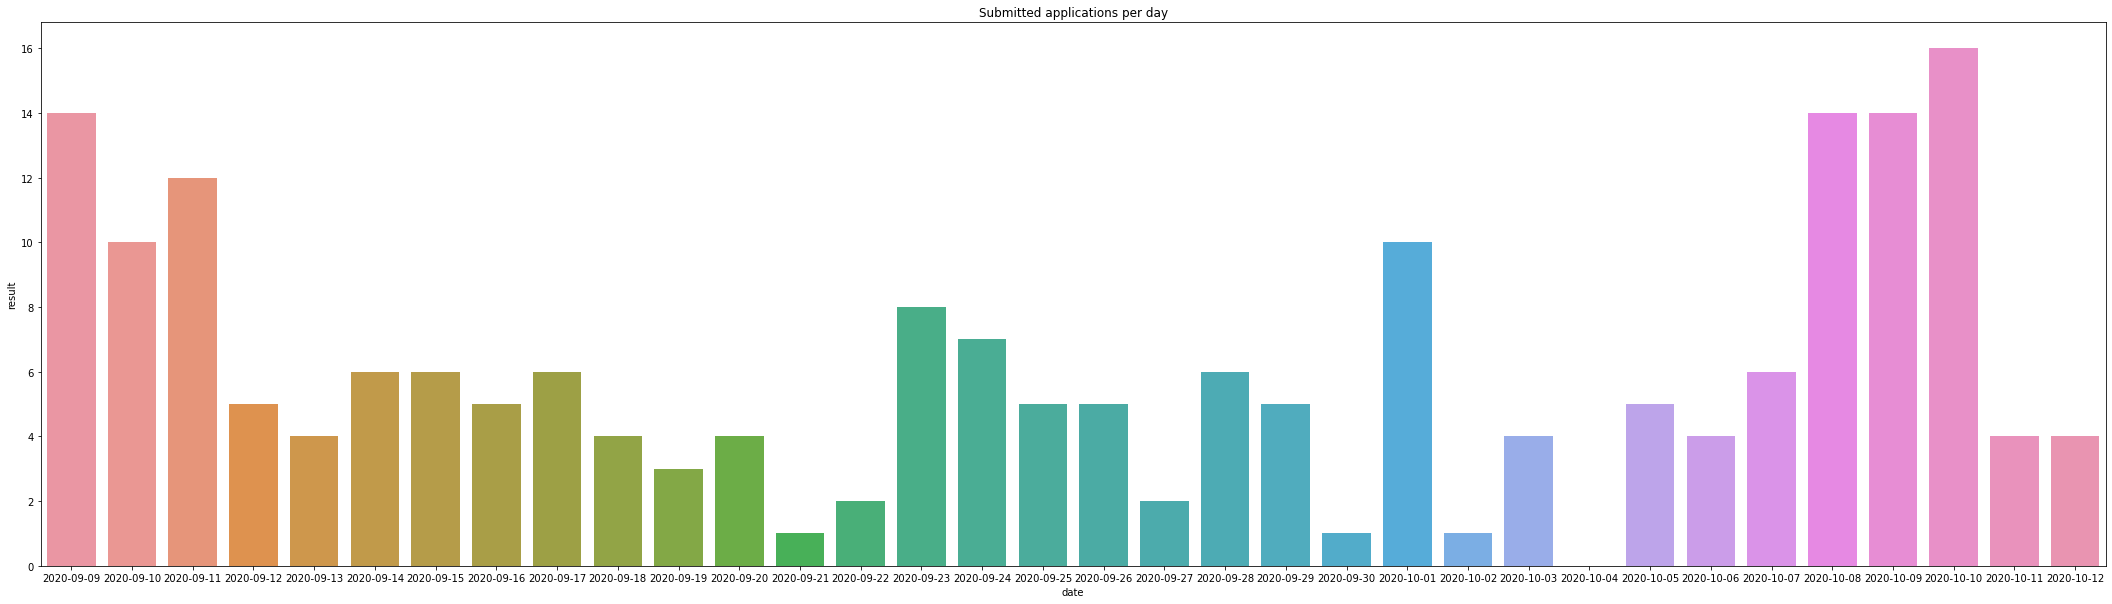

In [12]:
plt.figure(figsize=(37,10))
plt.title("Submitted applications per day")

sns.barplot(x=group.index, y=group['result'])

In [13]:
group2 = non_duplicated[['weekday','attempted', 'result']].groupby(['weekday']).sum()

group2.head()

,attempted,result
weekday,,
0,29,22
1,22,17
2,43,34
3,64,47
4,41,36


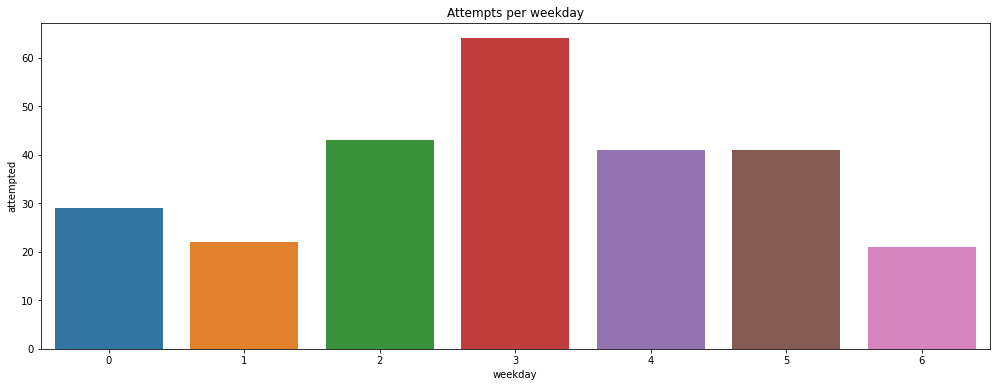

In [14]:
plt.figure(figsize=(17,6))
plt.title("Attempts per weekday")

sns.barplot(x=group2.index, y=group2['attempted'])

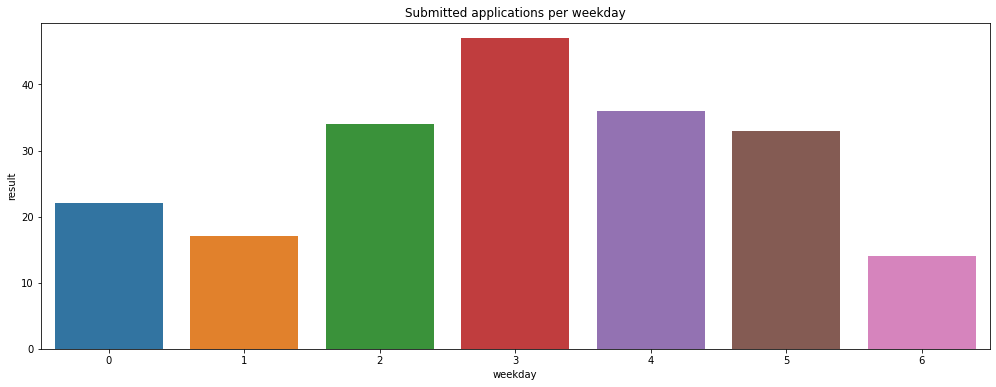

In [15]:
plt.figure(figsize=(17,6))
plt.title("Submitted applications per weekday")

sns.barplot(x=group2.index, y=group2['result'])

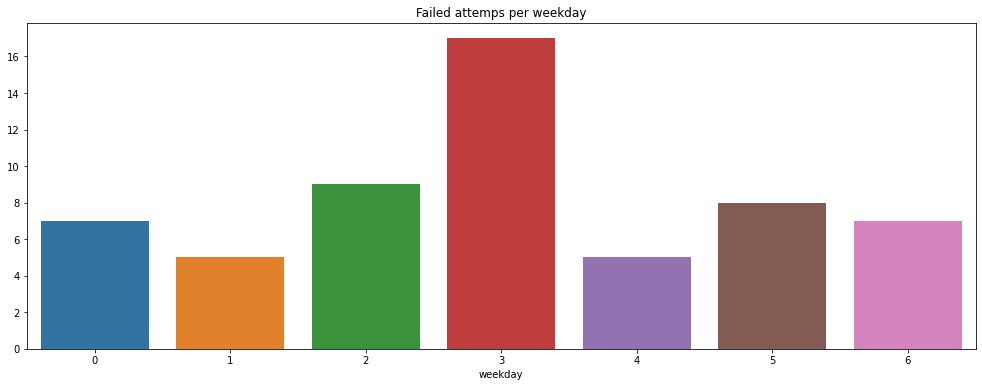

In [16]:
failed = group2['attempted'] - group2['result']

plt.figure(figsize=(17,6))

plt.title("Failed attemps per weekday")

sns.barplot(x=failed.index, y=failed)

It seems that there are more available jobs in the middle of the week (Wednesday, Thursday, and Friday).

I create another column with the dates when they called me (if so, 'nan' otherwise).

I can take the jobID from the url, so I look for the id of the row in order to change the date_call from 'nan' to the corresponding date of the call.

In [17]:
#2019339369
non_duplicated['date_call'] = np.nan

print(non_duplicated.query('jobID == 2019339369')['date_call']) # id is equal to 92
non_duplicated.loc[92,'date_call'] = datetime.date(2020, 9, 14)
print(non_duplicated.query('jobID == 2164722520')['date_call']) # id is equal to 950
non_duplicated.loc[950,'date_call'] = datetime.date(2020, 10, 8)

92   NaN
Name: date_call, dtype: float64
950    NaN
Name: date_call, dtype: object


Now we can see how many job applications have a response.

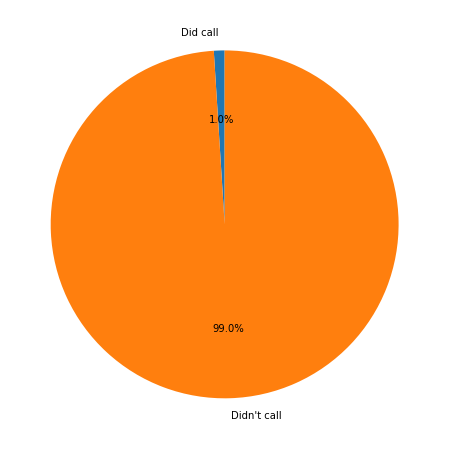

,Total applications,Number of calls
0,203,2


In [18]:
call = non_duplicated['date_call'].notnull().sum()
d_call = non_duplicated['result'].value_counts()[1] - call

p_call = call*100/d_call
p_dcall = 100 - p_call

# Creating dataset 
labels = "Did call", "Didn't call"
  
data = [p_call, p_dcall]
  
# Creating plot 
fig = plt.figure(figsize =(12, 8)) 
plt.pie(data, labels = labels, autopct='%1.1f%%', startangle=90) 
  
# show plot 
plt.show() 

pd.DataFrame({'Total applications':[non_duplicated['result'].value_counts()[1]], 'Number of calls':[call]}).head()


Let's see how it looks the applications per week.

In [19]:
per_week = non_duplicated[['attempted', 'result', 'week']].groupby(['week']).sum()
print(per_week)

      attempted  result
week                   
37           57      45
38           51      34
39           36      30
40           34      27
41           77      63
42            6       4


Week 37 was the first one and the bot wasn't run every day, and week 42 was run just one day, so we'll ignore both of them.

In [20]:
per_week.loc[(per_week.index > 37) & (per_week.index < 42)]

,attempted,result
week,,
38,51,34
39,36,30
40,34,27
41,77,63


We have to take into account that within week 38 I added new settings to look for more types of jobs. So the increment of attempts is normal, yet the results are more or less the same.

Nonetheless, on week 41 we notice a huge increment of attempts and submitted applications. It seems that during that week more job positions were offered on LinkedIn. I can confirm that since I received way more offers during this week from other websites.

# Conclusions

Finally, I achieved my goal, but unfortunately, it wasn't thanks to the bot.

My conclusions about the tool are the following:

1. There are a lot of job offers without an easy apply button (the obvious conclusion).

2. There are job offers with specific forms. If they weren't previously fulfilled the application will not be submitted.

3. Most of the jobs ask for experience. The bot doesn't care about that. A possible solution could be to add a new setting to include the seniority level, but there are a lot of inconsistent offers (they ask for a certain level of experience but the filter reflects a different level of seniority). This would mean a loss of potential jobs, so it's better if the bot sends as most applications as possible, even if the vast majority of the companies don't respond. 

4. The program fails whenever it reads a strange character. 

5. Just 1% of the applications were responded to, so it seems this bot isn't very useful (at least for entry-level engineers in Madrid).

6. October is a good month to search for a job. 

And that's all folks. I won't be updating this anymore since I already have a job. I hope you've enjoyed this little project. I also hope you're luckier than me if you plan to use this bot. 

You can see this whole project in GitHub, with some extra visualizations using Qlik: [https://github.com/manuelalfredocolladocenteno/Jobs-analytics](http://)

In case you're curious I'll tell you how many applications I submitted (approximately):

* LinkedIn (EasyApply button: bot + manual): 288

* Infojobs: 74

* Other websites: 17
 
* Company websites: Sadly, I didn't keep track of these, but they were at least 10. Anyway, I'm not counting them. 

So I sent a minimum of 379 applications and I was contacted by 15 companies (I'm just counting the contacts via phone call or video call).

Thanks for reading. 